In [13]:
import os
import sys
from pathlib import Path
from typing import Literal

import numpy as np

sys.path.append(str(Path(os.getcwd()).parent))
from seaborn import color_palette
from ipywidgets import widgets
import pandas as pd
import torch
from matplotlib import pyplot as plt
from gpa.datasets.attribution import DetectionGraph
from gpa.datasets.attribution import PriceAttributionDataset

In [2]:
dataset_dir = Path("..") / "data/price-graphs-i" / "val"
dataset = PriceAttributionDataset(root=dataset_dir)
products_df = pd.read_csv(dataset_dir / "raw" / "product_boxes.csv", index_col="attributionset_id")

In [70]:
def compute_precision_recall_undirected(
    pred_edges: torch.Tensor,
    gt_edges: torch.Tensor
) -> tuple[float, float, float]:
    def normalize_edges(edges: torch.Tensor) -> set:
        # Sort each edge (a, b) -> (min(a,b), max(a,b))
        sorted_edges = torch.sort(edges, dim=0).values
        return set(map(tuple, sorted_edges.t().tolist()))

    pred_set = normalize_edges(pred_edges)
    gt_set = normalize_edges(gt_edges)

    tp = len(pred_set & gt_set)
    fp = len(pred_set - gt_set)
    fn = len(gt_set - pred_set)

    pr = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    re = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = (2 * pr * re) / (pr + re) if (pr + re) > 0 else 0.0

    return pr, re, f1_score

def knn(
    centroids: torch.Tensor,
    product_indices: torch.LongTensor,
    price_indices: torch.LongTensor,
    n: int = 3,  # Number of nearest price tags to connect
    strategy: Literal["normal", "below"] = "normal"
) -> tuple[torch.LongTensor, int]:
    """
    From the provided centroids, return an edge index connecting each
    product with its `n` nearest price tags.

    Args:
        centroids (torch.Tensor): Bbox centroids of all nodes, with shape (num_nodes, dim).
        product_indices (torch.LongTensor): Indices of product nodes.
        price_indices (torch.LongTensor): Indices of price tag nodes.
        n (int): Number of nearest price tags to connect for each product.
        strategy: Distance strategy; normal: normal Euclidean distance; below: price tag must be below product bbox.
    Returns:
        torch.LongTensor: A (2, E) edge index connecting each product centroid with its `n` nearest price tags.
    """
    n = min(n, price_indices.size(0))
    product_centroids = centroids[product_indices]  # (P, D)
    price_centroids = centroids[price_indices]      # (Q, D)
    distances = torch.cdist(product_centroids, price_centroids, p=2)  # (P, Q)
    if strategy == "below":
        product_y = product_centroids[:, 1].unsqueeze(1)
        price_y = price_centroids[:, 1].unsqueeze(0)
        below_mask = price_y > product_y
        distances = distances.masked_fill(~below_mask, float('inf'))

    knn_distances, knn_indices = torch.topk(distances, k=n, largest=False)
    product_expanded = product_indices.unsqueeze(1).expand(-1, n)
    price_knn_indices = price_indices[knn_indices]
    no_match_mask = torch.isinf(knn_distances)
    price_knn_indices[no_match_mask] = -1
    edge_index = torch.stack(
        [
            product_expanded.reshape(-1),
            price_knn_indices.reshape(-1)
        ],
        dim=0
    )

    return edge_index, n

def plot_metrics(dataframe: pd.DataFrame):
    metrics = ['precision', 'recall', 'f1']
    colors = {'below': 'blue', 'normal': 'green'}

    for metric in metrics:
        plt.figure(figsize=(8, 5))

        for strategy in ['below', 'normal']:
            subset = dataframe[dataframe['strategy'] == strategy].sort_values('n')
            mean_col = f'mean_{metric}'
            std_col = f'std_{metric}'

            plt.plot(subset['n'], subset[mean_col], label=f'{strategy} (mean)', color=colors[strategy])
            plt.fill_between(subset['n'],
                             subset[mean_col] - subset[std_col],
                             subset[mean_col] + subset[std_col],
                             alpha=0.2,
                             color=colors[strategy],
                             label=f'{strategy} (± std)')

        plt.title(f'{metric.capitalize()} vs n')
        plt.xlabel('n')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

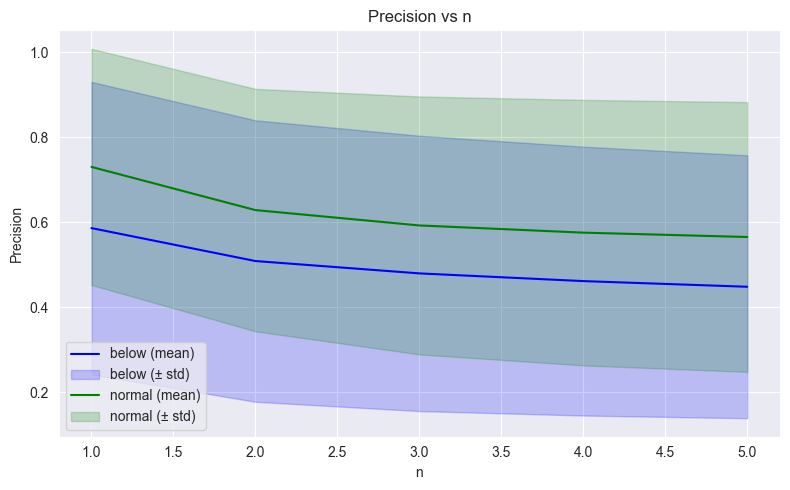

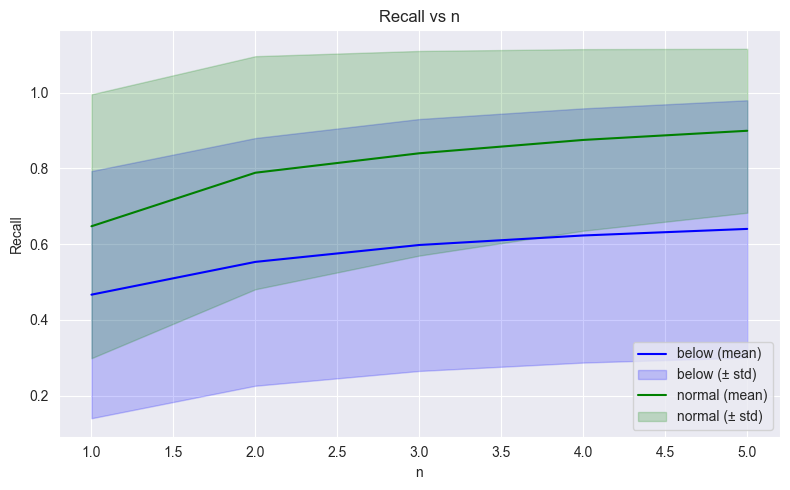

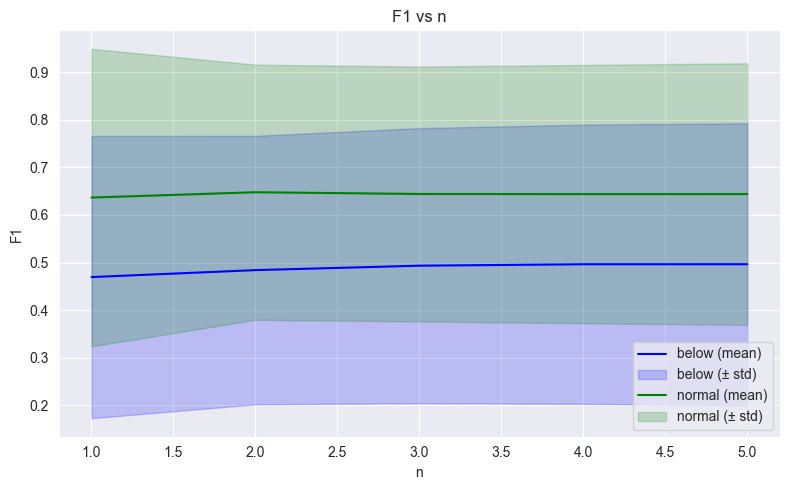

,n,strategy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1
0,1,normal,0.730755,0.277931,0.647348,0.348461,0.636554,0.312523
1,1,below,0.586705,0.344194,0.466710,0.326403,0.469510,0.296576
2,2,normal,0.629093,0.285331,0.788760,0.307755,0.647744,0.268067
3,2,below,0.509169,0.331284,0.553259,0.327082,0.484120,0.282098
4,3,normal,0.592932,0.303504,0.840124,0.270227,0.644067,0.267727
5,3,below,0.480082,0.324085,0.597898,0.332688,0.493450,0.289017
6,4,normal,0.575984,0.312481,0.875363,0.239797,0.643827,0.271324
7,4,below,0.461946,0.316403,0.623037,0.335710,0.496424,0.293383
8,5,normal,0.565740,0.317435,0.899564,0.216471,0.643891,0.274712
9,5,below,0.448612,0.309491,0.640373,0.339711,0.496478,0.296214


In [76]:
df = []
for n_value in [1, 2, 3, 4, 5]:
    for strategy in ["normal", "below"]:
        all_prec = []; all_rec = []; all_f1 = []
        for graph in dataset:
            graph: DetectionGraph
            pred, n_ = knn(
                centroids=graph.x[:, :2],
                product_indices=graph.product_indices,
                price_indices=graph.price_indices,
                n=n_value,
                strategy=strategy
            )
            gt = graph.gt_prod_price_edge_index
            precision, recall, f1 = compute_precision_recall_undirected(
                pred_edges=pred,
                gt_edges=gt
            )
            all_prec.append(precision)
            all_rec.append(recall)
            all_f1.append(f1)

        mean_precision, std_precision = np.array(all_prec).mean(), np.array(all_prec).std()
        mean_recall, std_recall = np.array(all_rec).mean(), np.array(all_rec).std()
        mean_f1, std_f1 = np.array(all_f1).mean(), np.array(all_f1).std()
        df.append({
            "n": n_value,
            "strategy": strategy,
            "mean_precision": mean_precision,
            "std_precision": std_precision,
            "mean_recall": mean_recall,
            "std_recall": std_recall,
            "mean_f1": mean_f1,
            "std_f1": std_f1,
        })
df = pd.DataFrame(df)
plot_metrics(df)
df

In [72]:
def plot_knn(
    g: DetectionGraph,
    n: int = 3,
    strategy: Literal["normal", "below"] = "normal"
) -> None:
    plt.close()
    predicted, _ = knn(
        centroids=g.x[:, :2],
        product_indices=g.product_indices,
        price_indices=g.price_indices,
        n=n,
        strategy=strategy
    )
    src, dest = predicted
    fig, axs = plt.subplots(1, 1, figsize=(15, 4))
    g.edge_index = torch.stack([src, dest], dim=0)
    g.edge_attr = torch.ones(len(src), 1)
    g.plot(ax=axs, prod_price_only=True, mark_wrong_edges=True)
    fig.tight_layout()
    fig.set_dpi(100)
    axs.set_title(f"KNN (n={n})", fontsize=10)
    plt.show()

def plot_scene_knn(idx: int, dataset: PriceAttributionDataset, n: int = 3, strategy: Literal["normal", "below"] = "normal") -> None:
    g: DetectionGraph = dataset[idx]
    return plot_knn(g, n=n, strategy=strategy)

In [74]:
display_func = lambda idx: plot_scene_knn(idx=idx, dataset=dataset, n=2, strategy="normal")
idx_slider = widgets.IntSlider(value=0, min=0, max=len(dataset)-1, step=1, description="Graph Index")
display(widgets.interact(display_func, idx=idx_slider))

interactive(children=(IntSlider(value=0, description='Graph Index', max=188), Output()), _dom_classes=('widget…

<function __main__.<lambda>(idx)>